In [71]:
import pandas as pd 
from model import MultiViewRNN
from utils import _load_config,load_checkpoint
from dataset import MultiViewDataset,get_train_loader
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader
import torch 
from metrics import compute_cosim

In [17]:
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
config_file=_load_config()
model=MultiViewRNN(config_file)
optimizer=optim.Adam(model.parameters(),lr=config_file['lr'])

/home/ubuntu/acoustic_stuff/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [80]:
#model2
model2=MultiViewRNN(config_file)
optimizer2=optim.Adam(model2.parameters(),lr=config_file['lr'])
step=load_checkpoint(checkpoint=torch.load('/home/ubuntu/acoustic_stuff/hindi-acoustic-word-embedding/checkpoints2/checkpoint_epoch_108.pth.tar'),model=model2,optimizer=optimizer2)

=> loading checkpoint


In [81]:
step

10302

In [5]:
model

MultiViewRNN(
  (net): ModuleDict(
    (view1): RNN_default(
      (rnn): LSTM(39, 512, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
    )
    (view2): RNN_default(
      (rnn): LSTM(83, 512, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
    )
  )
)

In [6]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

In [11]:
csv_path='/home/ubuntu/acoustic_stuff/hindi-acoustic-word-embedding/dataset/train_aligned_dataset/sampled_trainset.csv'

In [12]:
loader=get_train_loader(csv_file=csv_path,batch_size=config_file['train_batch_size'],loss_fn=config_file['loss_fn'])

In [13]:
batch=next(iter(loader))

In [14]:
batch.keys()

dict_keys(['view1_x1', 'view2_c1', 'view2_c2'])

In [23]:
def prepare_audio_input(mfcc):
    mfcc=mfcc.view(-1,mfcc.shape[2],mfcc.shape[1])
    mfcc=mfcc.to(DEVICE)

    return {'view1_x1':mfcc}

def prepare_text(one_hot):
    one_hot=one_hot.to(DEVICE)

    return {'view2_c1':one_hot} 

In [33]:
model.eval()
model=model.to(DEVICE)

In [82]:
model2.eval()
model2=model2.to(DEVICE)

In [83]:
audio_input=prepare_audio_input(batch['view1_x1'])
text_input=prepare_text(batch['view2_c1'])

In [113]:
audio_embedding=model2(audio_input)['x1']

In [114]:
text_embedding=model2(text_input)['c1']

In [86]:
audio_embedding[0]

tensor([ 0.0383,  0.0017,  0.0039,  ..., -0.0020, -0.0064,  0.0126],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [87]:
text_embedding[0]

tensor([-0.0154,  0.0004, -0.0007,  ..., -0.0030,  0.0158,  0.0481],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [115]:
audio_embedding=audio_embedding.unsqueeze(1)
audio_embedding[0].shape
text_embedding=text_embedding.unsqueeze(1)

In [116]:
audio_embeddings= audio_embedding.cpu().detach().numpy()   
text_embeddings = text_embedding.cpu().detach().numpy()


In [117]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [108]:
audio_embeddings[0].shape

(1, 1024)

In [132]:
combined_embeddings = np.vstack((audio_embeddings[30], text_embeddings[30]))

labels = np.array([0] * len(audio_embeddings[0]) + [1] * len(text_embeddings[0]))

n_samples = combined_embeddings.shape[0]
perplexity = min(30, n_samples - 1)
tsne = TSNE(n_components=2, perplexity=perplexity,random_state=42)
embeddings_2d = tsne.fit_transform(combined_embeddings)

def calculate_angle(v1, v2):
    unit_vector_1 = v1 / np.linalg.norm(v1)
    unit_vector_2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    return np.degrees(angle)


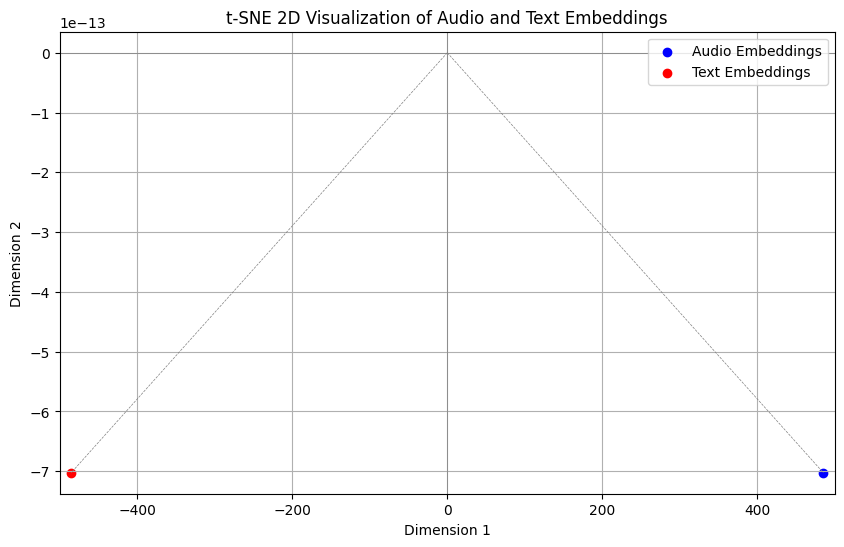

In [133]:
plt.figure(figsize=(10, 6))

plt.scatter(embeddings_2d[labels == 0, 0], embeddings_2d[labels == 0, 1], c='blue', label='Audio Embeddings')

plt.scatter(embeddings_2d[labels == 1, 0], embeddings_2d[labels == 1, 1], c='red', label='Text Embeddings')

origin = np.array([0, 0])
for i in range(embeddings_2d.shape[0]):
    plt.plot([0, embeddings_2d[i, 0]], [0, embeddings_2d[i, 1]], 'grey', linestyle='--', lw=0.5)
plt.xlim([-500, 500])
#plt.ylim([-10, 10])

plt.title('t-SNE 2D Visualization of Audio and Text Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.grid(True)
plt.legend()
plt.show()

In [134]:
audio_embedding.shape

torch.Size([32, 1, 1024])

In [142]:
cosim=compute_cosim(audio_emb=audio_embedding[31],text_emb=text_embedding[31])

In [143]:
cosim.item()

-0.8340373039245605

In [144]:
angle=np.degrees(np.arccos(cosim.item()))


In [145]:
angle

146.51572837415324

In [1]:
import pandas as pd 
csv_path='/home/ubuntu/acoustic_stuff/hindi-acoustic-word-embedding/dataset/train_aligned_dataset/sampled_devset.csv'
df=pd.read_csv(csv_path)

In [59]:
from dataset import get_dev_loader
from model import MultiViewRNN
from utils import _load_config,load_checkpoint
import torch.optim as optim
import torch 

config_file=_load_config()
model=MultiViewRNN(config_file)
optimizer=optim.Adam(model.parameters(),lr=config_file['lr'],weight_decay=config_file['lr'])

step=load_checkpoint(torch.load('/home/ubuntu/acoustic_stuff/hindi-acoustic-word-embedding/checkpoints4/checkpoint_epoch_10.pth.tar'),model,optimizer)

=> loading checkpoint


In [5]:
dataset=get_dev_loader(csv_file=csv_path,batch_size=32)

In [62]:
batch=next(iter(dataset))

/home/ubuntu/acoustic_stuff/hindi-acoustic-word-embedding/dataset.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.nn.functional.pad(torch.tensor(seq), (0, 0, 0, max_seq_length - len(seq)), 'constant', padding_value)


In [60]:
DEVICE=torch.device("cuda")
model=model.to(DEVICE)
model.eval()

MultiViewRNN(
  (net): ModuleDict(
    (view1): RNN_default(
      (rnn): LSTM(39, 512, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
    )
    (view2): RNN_default(
      (rnn): LSTM(83, 512, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
    )
  )
)

In [63]:
mfcc=batch["mfcc"]
mfcc=mfcc.view(-1,mfcc.shape[2],mfcc.shape[1])
mfcc=mfcc.to(DEVICE)
mfcc_input={"view1_x1":mfcc}
audio_emb=model(mfcc_input)["x1"] 

input_text_tensor=batch["sampled_one_hot"]
batch_size=input_text_tensor.shape[0]
sampled_shape=input_text_tensor.shape[1]
input_text_tensor=input_text_tensor.view(input_text_tensor.shape[0]*sampled_shape,
                                                        input_text_tensor.shape[2],
                                                        input_text_tensor.shape[3])
input_text_tensor=input_text_tensor.to(DEVICE)
input_one_hot={"view2_c1":input_text_tensor}
out_one_hot=model(input_one_hot)["c1"]
text_emb=out_one_hot.view(batch_size,
                                        sampled_shape,
                                        out_one_hot.shape[1])
            
lev_distances=batch["lev_scores"].to(DEVICE)

In [10]:
audio_emb.shape

torch.Size([32, 1024])

In [11]:
text_emb.shape

torch.Size([32, 20, 1024])

In [12]:
lev_distances.shape

torch.Size([32, 20])

In [20]:
lev_distances[24]

tensor([0, 0, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')

In [22]:
import torch.nn.functional as F

normalized_audio_embeddings = F.normalize(audio_emb, p=2, dim=1)
normalized_text_embeddings = F.normalize(text_emb, p=2, dim=2)

In [23]:
expanded_audio_embeddings = normalized_audio_embeddings.unsqueeze(1)
expanded_audio_embeddings.shape


torch.Size([32, 1, 1024])

In [24]:
cosine_similarities = torch.sum(expanded_audio_embeddings * normalized_text_embeddings, dim=2)


In [25]:
cosine_similarities.shape

torch.Size([32, 20])

In [27]:
cosine_similarities[0]

tensor([0.5449, 0.5449, 0.5946, 0.4418, 0.5529, 0.4133, 0.0796, 0.6370, 0.4662,
        0.4484, 0.6449, 0.4662, 0.5364, 0.4592, 0.6256, 0.4484, 0.5404, 0.3307,
        0.2845, 0.7197], device='cuda:0', grad_fn=<SelectBackward0>)

In [36]:
cosine_sim=cosine_similarities[0].cpu().detach()
sorted_indices_desc = torch.argsort(cosine_sim, descending=True)

# Initialize a rank tensor
ranks = torch.zeros_like(cosine_sim, dtype=torch.long)

# Assign ranks based on sorted indices
ranks[sorted_indices_desc] = torch.arange(len(cosine_sim))

In [37]:
ranks

tensor([ 7,  6,  4, 15,  5, 16, 19,  2, 11, 13,  1, 10,  9, 12,  3, 14,  8, 17,
        18,  0])

In [ ]:
elevant_ranks=ranks[i].masked_select(lev_distances[i]==0).sort()[0]


In [42]:
cosine_similarities.device

device(type='cuda', index=0)

In [43]:
indices=torch.argsort(cosine_similarities, dim=1, descending=True)
ranks = torch.zeros_like(cosine_similarities, dtype=torch.long)

In [48]:
indices.device

device(type='cuda', index=0)

In [49]:
#indices.device
ranks.device
batch_size, seq_length = cosine_similarities.shape
for i in range(batch_size):
        ranks[i,indices[i]] = torch.arange(seq_length,device=cosine_similarities.device)

In [50]:
import torch.nn.functional as F

def get_indices(audio_embedding,text_embedding):
    
    normalized_audio_embeddings = F.normalize(audio_embedding, p=2, dim=1)
    normalized_text_embeddings = F.normalize(text_embedding, p=2, dim=2)

    expanded_audio_embeddings = normalized_audio_embeddings.unsqueeze(1)

    cosine_similarities = torch.sum(expanded_audio_embeddings * normalized_text_embeddings, dim=2)

    del normalized_audio_embeddings
    del normalized_text_embeddings
    del expanded_audio_embeddings
    torch.cuda.empty_cache() 

    indices=torch.argsort(cosine_similarities, dim=1, descending=True)
    ranks = torch.zeros_like(cosine_similarities, dtype=torch.long)
    ranks=ranks.to(DEVICE)
    batch_size, seq_length = cosine_similarities.shape
    for i in range(batch_size):
        ranks[i,indices[i]] = torch.arange(seq_length,device=cosine_similarities.device)

    del cosine_similarities
    torch.cuda.empty_cache()

    return ranks  

def crossview_ap(audio_embedding,text_embedding,lev_distances):

    indices=get_indices(audio_embedding=audio_embedding,text_embedding=text_embedding)
    
    average_precission=ranked_batch_ap(lev_distances,indices)

    return average_precission

def ranked_batch_ap(lev_distances, cosine_ranks):

    batch_ap=0.0
    num_elements=lev_distances.size(0)

    for i in range(num_elements):
        
        relevant_ranks=cosine_ranks[i].masked_select(lev_distances[i]==0).sort()[0]
        if relevant_ranks.numel()==0:
            continue 

        pos_indices=torch.arange(1,relevant_ranks.size(0)+1,device=relevant_ranks.device).float()
        precision_at_k=pos_indices/(relevant_ranks+1)

        average_precission_i=precision_at_k.sum()/relevant_ranks.size(0)
        batch_ap+=average_precission_i
    
    if num_elements>0:
        batch_ap/=num_elements
    
    return batch_ap.item()

In [64]:
crossview_ap(audio_emb,text_emb,lev_distances)

0.26965755224227905

In [13]:
from dataset import get_train_loader
from utils import _load_config

config_file=_load_config()

csv_path='/home/ubuntu/acoustic_stuff/hindi-acoustic-word-embedding/dataset/train_aligned_dataset/sampled_trainset.csv'

loader=get_train_loader(csv_file=csv_path,batch_size=config_file['train_batch_size'],loss_fn=config_file['loss_fn'])

In [14]:
batch=next(iter(loader))

AttributeError: 'int' object has no attribute 'append'